In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

base_dir = '/Volumes/JS/QuickDraw'
test_path = os.path.join(base_dir, '/test_simplified.csv')

In [3]:
from ast import literal_eval
from glob import glob
import pandas as pd

all_train_paths = glob(os.path.join(base_dir, 'train_simplified', '*.csv'))
cols = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

In [10]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


def preprocessRawStrokes(raw_strokes):
    """ process raw input strokes from .csv file.
    Stack all stroke vector to a Nx3 array. c_stroke[:,2] indicates if this is a start of a new stroke vector
    with 1 or 2. Then make all strokes the same length
    """
    stroke_vec = literal_eval(raw_strokes) # read stroke string vector to list
    
    # unwrap the list
    in_strokes = [(xi, yi, i) for i, (x, y) in enumerate(stroke_vec) for xi, yi in zip(x,y)]    
    c_strokes = np.stack(in_strokes)

    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1] + np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    
    # make all strokes same length by padding the strokes with zero after
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=196, 
                         padding='post').swapaxes(0, 1)


def read_batch(path, samples=5, 
               start_row=0,
               n_rows=1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in path:
        c_df = pd.read_csv(c_path, nrows=n_rows, skiprows=start_row)
        c_df.columns=['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].map(preprocessRawStrokes)
    
    return full_df

In [11]:
def generateDf(n_train, n_valid, n_test, n_strokes, all_train_paths):
    # for each .csv file randomly sample 750 training instances, 75 valid instances, and 50 test instances
    # TODO: place 1 to improve
    train_args = dict(samples=n_train, start_row=0, n_rows=int(n_train*1.5), path=all_train_paths)
    valid_args = dict(samples=n_valid, start_row=train_args['n_rows']+1, n_rows=n_valid+25, path=all_train_paths)
    test_args = dict(samples=n_test, start_row=valid_args['n_rows']+train_args['n_rows']+1, 
                     n_rows=n_test+25, paht=all_train_paths)

    train_df = read_batch(**train_args)
    valid_df = read_batch(**valid_args)
    test_df = read_batch(**test_args)

    word_encoder = LabelEncoder()
    word_encoder.fit(train_df['word'])

    print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))
    return train_df, valid_df, test_df, word_encoder

In [ ]:
TRAIN_SAMPLES = 750  # for each .csv training category file
VALID_SAMPLES = 75
TEST_SAMPLES = 50
STROKE_COUNT = 196

train_df, valid_df, test_df, word_encoder = generateDf(TRAIN_SAMPLES, VALID_SAMPLES, TEST_SAMPLES, 
                                                       STROKE_COUNT, all_train_paths)

In [27]:
from keras.utils.np_utils import to_categorical

def getXYfromDf(df):
    """ Generate feature x and label y for input dataframe 
    """
    x = np.stack(df['drawing'], axis=0)
    y = to_categorical(word_encoder.transform(df['word'].values))
    return x, y

In [28]:
x_train, y_train = getXYfromDf(train_df)
x_valid, y_valid = getXYfromDf(valid_df)
x_test, y_test = getXYfromDf(test_df)

In [31]:
print(x_train.shape)   # 340 .csv file in total sampling 750 instances for each
print(x_valid.shape)
print(x_test.shape)

(255000, 196, 3)
(25500, 196, 3)
(17000, 196, 3)


In [118]:
def demo():
    """ demonstarte how a pic made up of stroke vectors
    Each stroke_idx represents a stroke
    """
    fig, m_axs = plt.subplots(3, 3, figsize=(16, 16))
    rand_idxs = np.random.choice(range(x_train.shape[0]), size = 9)

    for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
        test = x_train[c_id]
        test = test[test[:,2] > 0, :]  # when the stroke index=0 means it's invalid generate by padding 0
        stroke_idx = np.cumsum(test[:,2] - 1)
        for i in np.unique(stroke_idx):   # visualize each stroke vector
            c_ax.plot(test[stroke_idx==i,0], np.max(test[:,1]) - test[stroke_idx==i,1], '.-')
#         c_ax.axis('off')   # display axis or not
        c_ax.set_title(word_encoder.classes_[np.argmax(y_train[c_id])])

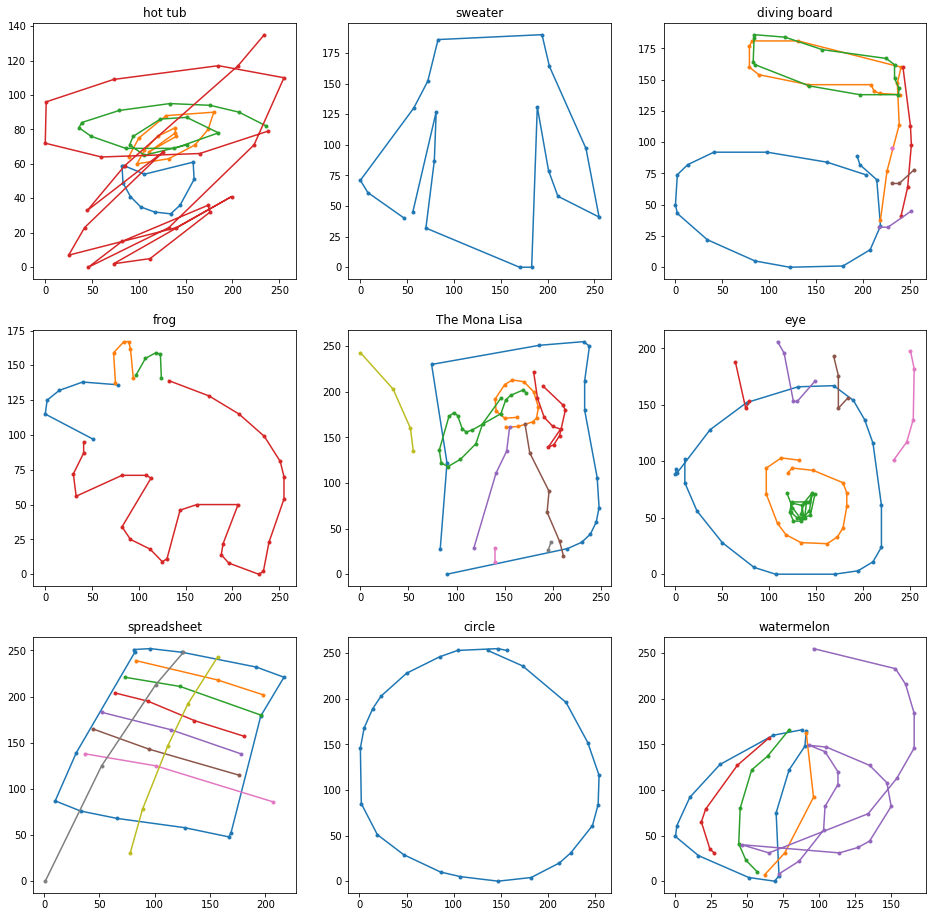

In [119]:
demo()